In [0]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

In [0]:
# Read file data into CSR Matrix
def getCSRMatrix(fname):
  with open(fname) as f:
          doc_id = f.readlines()
          n_rows = len(doc_id)
          n_cols = non_zero = 0
          for word in range(n_rows):
              doc_array = doc_id[word].split()
              doc_array = [int(i) for i in doc_array] 
              non_zero += len(doc_array)/2
              ncols_temp = max(doc_array)
              if ncols_temp > n_cols:
                n_cols = ncols_temp
          val = np.zeros(int(non_zero))
          ind = np.zeros(int(non_zero))
          row_ptr = np.zeros(n_rows+1)
          n = 0 
          for word in range(n_rows):
              doc_array = doc_id[word].split()
              doc_array = [int(i) for i in doc_array]
              for i in range(0, len(doc_array), 2):
                val[n] = doc_array[i+1]
                ind[n] = doc_array[i] - 1
                n += 1
              row_ptr[word+1] = n 
          
          return csr_matrix((val, ind, row_ptr), shape=(n_rows, n_cols), dtype=np.int)

In [0]:
# Convert the matrix in Inverse Document Frequency form
def getCSRIDF(data):
  return TfidfTransformer(norm='l2').fit_transform(data)

In [0]:
# Dimensionality Reduction using TruncatedSVD
def getTSVD(data,n_comp):
  tsvd = TruncatedSVD(n_components=n_comp)
  csr_tsvd = tsvd.fit_transform(data)
  return csr_tsvd

In [0]:
# KMeans that forms 2 clusters for the BisectingKMeans
def KMeans(data,num_of_iter):

  # compute the initial centroids randomly
  np.random.RandomState(20)
  random_idx = np.random.permutation(data.shape[0])
  centroids = data[random_idx[:2]]

  # get the cosine similarity by using the dot product of the data matrix and the centroids
  similarity_matrix = data.dot(centroids.T)
  
  for j in range(num_of_iter):
    clusters = list()
    c1 = list()
    c2 = list()

    for i in range(similarity_matrix.shape[0]):
      row = similarity_matrix[i]

      # get index of the maximum element
      max_element_idx = np.where(row == max(row))[0][0]
      if max_element_idx == 0:
        c1.append(i)
      else:
        c2.append(i)

    if len(c1) > 1:
      clusters.append(c1)
    if len(c2) > 1:
      clusters.append(c2)

    # recompute the centroids from the mean of the newly built clusters
    centroids = list()
    for i in range(0,2):
        cluster = data[clusters[i],:]
        mean = cluster.mean(0)
        centroids.append(mean)
    centroids = np.asarray(centroids)
  return c1,c2

In [0]:
# to compute the Squared error within the clusters and return the index of the max element
def computeSquaredError(data, clusters):
    
    SSE = list()
    for cluster in clusters:
        distance = data[cluster,:] - np.mean(data[cluster,:])
        sse = np.sum(np.square(distance))
        SSE.append(sse)
        
    SSE = np.asarray(SSE)
    # get the index of the max element from the SSE
    index = np.where(SSE == max(SSE))[0][0]
           
    return index

In [0]:
# Bisecting KMeans
def BisectingKMeans(data,no_of_clusters,num_of_iter):

    clusters = list()
    initial_cluster = list()

    # get all the elements in the initial cluster
    for i in range(data.shape[0]):
        initial_cluster.append(i)

    clusters.append(initial_cluster)

    # apply KMeans for the specified number of clusters
    while len(clusters) < no_of_clusters:
      
      idx = computeSquaredError(data,clusters)
      temp = clusters[idx]
      c1, c2 = KMeans(data[temp,:], num_of_iter)
      del clusters[idx]

      C1 = list()
      C2 = list()

      for index in c1:
          C1.append(temp[index])
          
      for index in c2:
          C2.append(temp[index])
      
      clusters.append(C1)
      clusters.append(C2)
    
    ClusterID = np.zeros(data.shape[0])

    for index, cluster in enumerate(clusters):
        for idx in cluster:
            ClusterID[idx] = index + 1
    return ClusterID

In [0]:
# Forming clusters and checking the accuracy using S for different number of components in 
# dimensionality reduction and number of iterations

f_name = "/content/drive/My Drive/Assignments/255/Programming Assignment 1/train.dat.txt"
cm = getCSRMatrix(f_name)
cm_idf = getCSRIDF(cm.copy())

In [85]:
K = list()
scores = list()
cm_tsvd = getTSVD(cm_idf.copy(),100)
for k in range(3, 22, 2):
    ClusterID = BisectingKMeans(cm_tsvd.copy(), k, 10)
    score = davies_bouldin_score(cm_tsvd, ClusterID)
    K.append(k)
    scores.append(score)
    
    print ("K=",k," Davies Bouldin Score = ", score)

K= 3  Davies Bouldin Score =  6.214236313891952
K= 5  Davies Bouldin Score =  7.97118602356183
K= 7  Davies Bouldin Score =  6.8669411353511505
K= 9  Davies Bouldin Score =  6.347048715581656
K= 11  Davies Bouldin Score =  5.735955007016913
K= 13  Davies Bouldin Score =  6.58653444729418
K= 15  Davies Bouldin Score =  6.673625782718408
K= 17  Davies Bouldin Score =  5.8898723716504975
K= 19  Davies Bouldin Score =  5.696782879700683
K= 21  Davies Bouldin Score =  5.3663395228997555


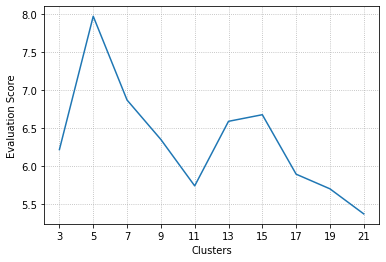

In [87]:
plt.plot(K, scores)
plt.xticks(K, K)
plt.xlabel('Clusters')
plt.ylabel('Evaluation Score')
plt.grid(linestyle='dotted')
plt.show()

In [52]:
# comps = 500, iters = 10
cm_tsvd = getTSVD(cm_idf,10)
clusterID = BisectingKMeans(cm_tsvd,7,10)
score = davies_bouldin_score(cm_tsvd,clusterID)
print(score)

2.265837762929457


In [0]:
# comps = 1000, iters = 10
cm_tsvd_1000 = getTSVD(cm_idf,1000)
clusterID_1000 = BisectingKMeans(cm_tsvd_1000,7,10)
score_1000 = davies_bouldin_score(cm_tsvd_1000,clusterID_1000)
print(score_1000)

In [0]:
# comps = 500, iters = 100
cm_tsvd = getTSVD(cm_idf,500)
clusterID = BisectingKMeans(cm_tsvd,7,100)
score = davies_bouldin_score(cm_tsvd,clusterID)
print(score)

In [0]:
# comps = 1000, iters = 100
cm_tsvd = getTSVD(cm_idf,1000)
clusterID = BisectingKMeans(cm_tsvd,7,100)
score = davies_bouldin_score(cm_tsvd,clusterID)
print(score)

In [0]:
# comps = 200, iters = 100
cm_tsvd = getTSVD(cm_idf,200)
clusterID = BisectingKMeans(cm_tsvd,7,100)
score = davies_bouldin_score(cm_tsvd,clusterID)
print(score)

In [0]:
# comps = 100, iters = 10
cm_tsvd = getTSVD(cm_idf,100)
clusterID = BisectingKMeans(cm_tsvd,7,10)
score = davies_bouldin_score(cm_tsvd,clusterID)
print(score)

In [0]:
# comps = 200, iters = 10
cm_tsvd = getTSVD(cm_idf,200)
clusterID = BisectingKMeans(cm_tsvd,7,10)
score = davies_bouldin_score(cm_tsvd,clusterID)
print(score)

In [0]:
# writing the outpot to output.csv file in the format (ItemID, ClusterID)
outputFile = open("/content/drive/My Drive/Assignments/255/Programming Assignment 1/output.csv","w+")
outputFile.write("ItemID,ClusterID" + '\n')
for i in range(len(clusterID)):
  outputFile.write(str(i+1) + "," + str(clusterID[i]) + '\n')
outputFile.close()